# Import

In [153]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import statsmodels.api as sm

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator, interp1d
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from joblib import Parallel, delayed 
import pandas as pd
from routines_model import *
from routines_GA import *
from multiprocessing import Pool
import multiprocessing
import pickle
import emcee
import corner
import pygtc 
import os

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from schwimmbad import JoblibPool

%load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload
# %matplotlib widget

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [4]:
data_Fe = pd.read_excel("ODP1260/ODP 1260_Fe_80-135.5m.xlsx")
data_Fe = data_Fe.values

c:\Users\hhnam\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


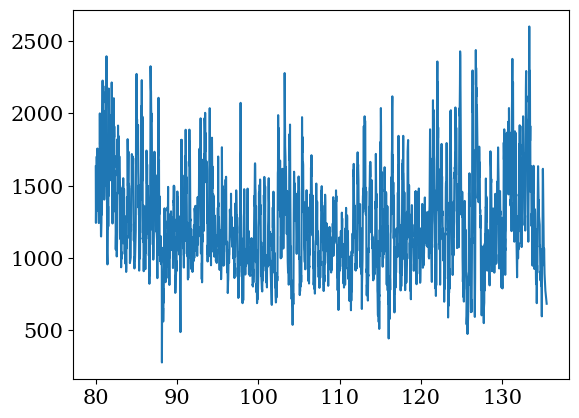

In [82]:
depth = data_Fe[:,0]
depth_lims = depth[0], depth[-1]
# depth_lims = 90, 125
ind = (depth>=depth_lims[0]) & (depth<=depth_lims[1])
y_data = data_Fe[ind,1]
depth = depth[ind]
# depth_original = depth 
lowess = sm.nonparametric.lowess(y_data, depth, frac=.3).T
# y = y_ori - lowess[1]
y = y_data-lowess[1]
# y = y_data - y_data.mean()
y = y/y.std()
%matplotlib inline

plt.figure()
plt.plot(data_Fe[:,0], data_Fe[:,1])

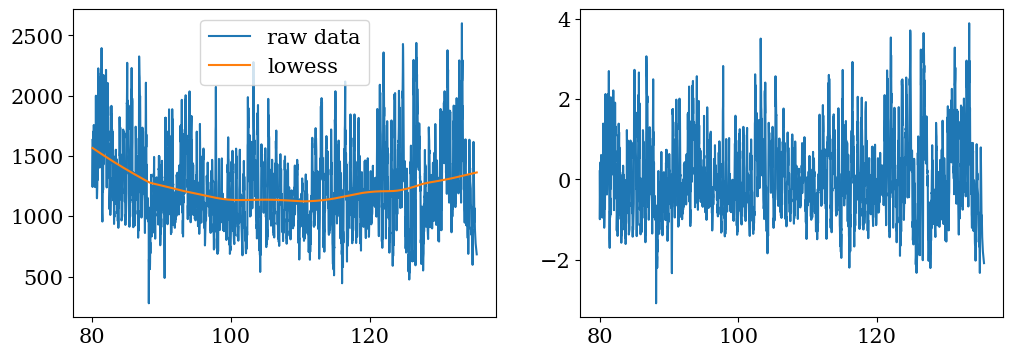

In [83]:
%matplotlib inline
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(depth, y_data, label="raw data")
plt.plot(depth, lowess[1], label="lowess")
plt.legend()
# plt.plot(depth, ydata_ma)
# plt.plot(depth, ydata-ydata_ma)
plt.subplot(1,2,2)
plt.plot(depth, y)


Age model by visual tuning

In [6]:
df_age_model = pd.read_csv("ODP1260/ggge20293-sup-0011-suppinfo06.txt", delimiter="\t")
depth_age_nominal = df_age_model[["Depth (rmcd)", "La2004 age (Ma)"]].to_numpy().T
depth_age_nominal = depth_age_nominal[:,:-1]
# depth_age_nominal[1] = depth_age_nominal[1]*1e3
df_age_model

,Depth (rmcd),La2004 age (Ma)
0,37.60,39.786
1,44.42,40.094
2,45.04,40.122
3,45.48,40.145
4,45.86,40.165
...,...,...
177,133.96,43.943
178,134.50,43.967
179,135.06,43.987
180,135.62,44.008


In [7]:
# ind = (depth_age_nominal[0]>=depth_lims[0]) & (depth_age_nominal[0]<=depth_lims[1])
# depth_age_nominal = depth_age_nominal[:, ind]
invSR_nominal = np.gradient(depth_age_nominal[1], depth_age_nominal[0])
func_invSR_nominal = interp1d(depth_age_nominal[0], invSR_nominal, kind="nearest" )
func_time_nominal = interp1d(depth_age_nominal[0], depth_age_nominal[1] )
# invSR_nominal = invSR_nominal[ind]
# SR_nominal = 1/invSR_nominal

Text(0.5, 0, 'm')

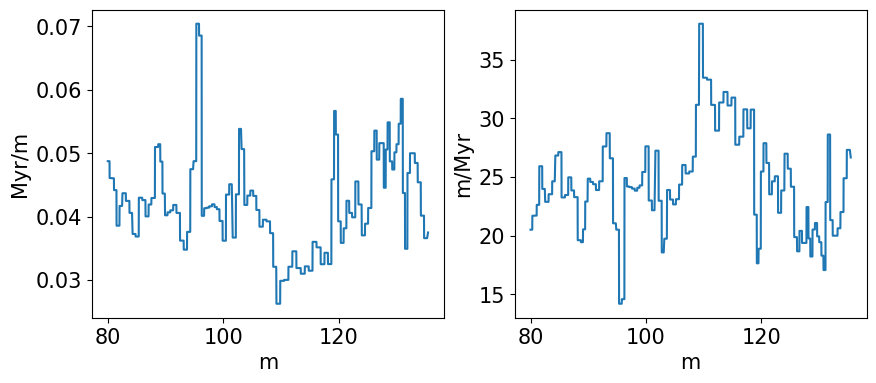

In [8]:
plt.figure(figsize=(10,4))
# plt.plot(*depth_age_nominal)
plt.subplot(1,2,1)
# plt.step(depth_age_nominal[0], invSR_nominal, where="mid")
plt.plot(depth, func_invSR_nominal(depth))
plt.ylabel("Myr/m")
plt.xlabel("m")
plt.subplot(1,2,2)
plt.plot(depth, 1/func_invSR_nominal(depth))
# plt.step(depth_age_nominal[0], SR_nominal)
plt.ylabel("m/Myr")
plt.xlabel("m")

# Model

In [10]:
coef_time = 1e6


b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022 #
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
phi_k = phi_k/180/3600*np.pi
muy_k = muy_k/180/3600*np.pi*coef_time

p0 = 50.467718
# p0 = 40
p0 = p0/180/3600*np.pi*coef_time

# b_k

ordering = [4, 1, 3, 2, 0]
b_k = b_k[ordering]
g_k = muy_k[ordering]
phi_k = phi_k[ordering]


# fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
# fe_k = fe_k/180/3600*np.pi*coef_time

fe_k =  np.array([g_k[1]-g_k[4], g_k[3]-g_k[4] , g_k[3]-g_k[1], g_k[2]-g_k[4], g_k[2]-g_k[1]])

fs = np.hstack([g_k + p0, fe_k])
print(fs)
print(2*np.pi/fs)

[271.72398927 280.82533348 328.87002991 331.50547223 265.31565416
  15.50967932  66.18981807  50.68013875  63.55437575  48.04469643]
[0.02312341 0.022374   0.01910538 0.01895349 0.02368192 0.40511381
 0.09492677 0.12397727 0.09886314 0.13077792]


## Optimize

In [103]:
# N_population = 128 # number of individual in population 
# N_generations_max = 12
N_genes = 16 # number of intial gene in an individial of the population 
# depth_genes = np.linspace(0,1,N_genes)
depth_genes = np.linspace(depth_lims[0], depth_lims[1], N_genes)
# true_genes = func_inv_SR(depth_genes)
invSR_lims = [0.02, 0.1]
# fs = muy_k + p0
fs = np.hstack([g_k + p0, fe_k])
# fs =  np.array([f1, f2])
interpolator = interpolate_Akima
# interpolator = interpolate_CubicSpline
invSR_to_predx =  partial(invSR_to_pred,  data=[depth, y], invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)

n_pieces = 3
metric_optimal = metric_piecewise([depth_genes, func_invSR_nominal(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
# interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(np.random.rand(len(depth_genes)), out)
out

[0.12316497 0.12613258 0.05952031]


{'F': array([-0.03413911, -0.01076252,  0.00223435])}

## With nominal age model

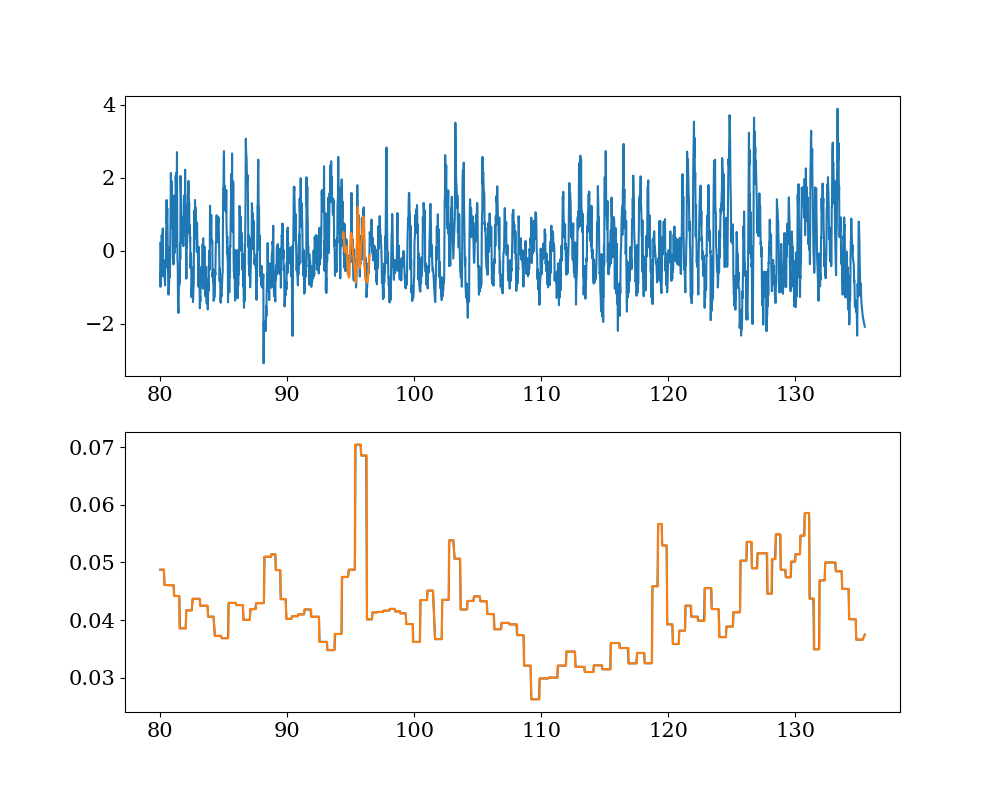

In [70]:
%matplotlib widget
depth_genes_test = np.linspace(depth_lims[0], depth_lims[1], 1000)

i0= 700; istep = 100
data = depth[i0:i0+istep], y[i0:i0+istep]
invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
time, y_pred = invSR_to_predx([depth_genes_test, func_invSR_nominal(depth_genes_test)])
plt.figure(figsize=(10,8))
plt.subplot(2, 1,1)
plt.plot(depth, y)
plt.plot(data[0], y_pred)
# plt.plot(depth, y_pred)

# plt.plot(func_time_nominal(depth)-func_time_nominal(depth[0]), y)
# plt.plot(time, y_pred)
plt.subplot(2,1,2)
# plt.plot(depth, y)
# plt.plot(depth, y_pred)
invSR_reconstruct = interpolator([depth_genes_test, func_invSR_nominal(depth_genes_test)], depth )
plt.plot(depth, invSR_reconstruct)
plt.plot(depth, func_invSR_nominal(depth))

# plt.plot(depth, time)

## GA

In [104]:
algorithm = NSGA2(
    pop_size=300,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 500)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# X = res.X
# F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      300 |     28 |             - |             -
     2 |      400 |     35 |  0.0323391334 |             f
     3 |      500 |     39 |  0.0268906286 |         ideal
     4 |      600 |     44 |  0.1051273578 |         nadir
     5 |      700 |     44 |  0.0714105714 |         ideal
     6 |      800 |     48 |  0.1691644904 |         nadir
     7 |      900 |     55 |  0.0212161241 |             f
     8 |     1000 |     29 |  0.0653333718 |         ideal
     9 |     1100 |     34 |  0.0425327867 |         ideal
    10 |     1200 |     38 |  0.0599918035 |         ideal
    11 |     1300 |     39 |  0.1231688590 |         ideal
    12 |     1400 |     23 |  0.0451328675 |         ideal
    13 |     1500 |     25 |  0.1859397255 |         nadir
    14 |     1600 |     30 |  0.0954651139 |         ideal
    15 |     1700 |     34 |  0.2021961263 |         nadir
    16 |     1800 |     37 |  0.0841482891 |         ide

In [56]:
# res = res_ensemble[-1]
# depth_genes = depth_genes_ensemble[-1]

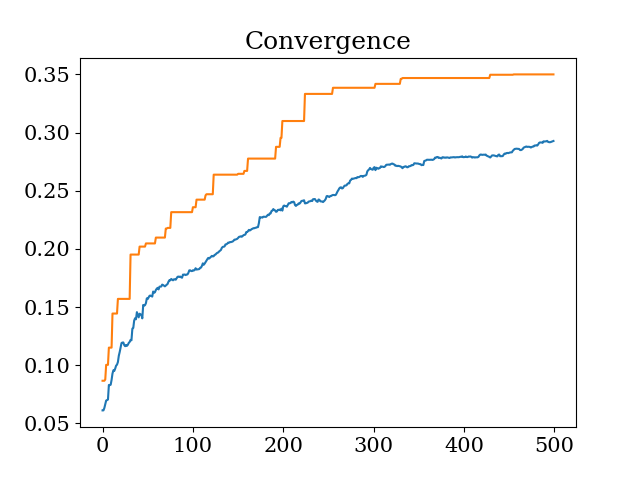

In [105]:
# opt = -np.array([e.opt[0].F for e in res.history])
opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
opt_max = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

plt.figure()
plt.title("Convergence")
# plt.plot(opt.mean(axis=1), "--")
plt.plot(opt_mean)
plt.plot(opt_max)

# plt.yscale("log")
plt.show()


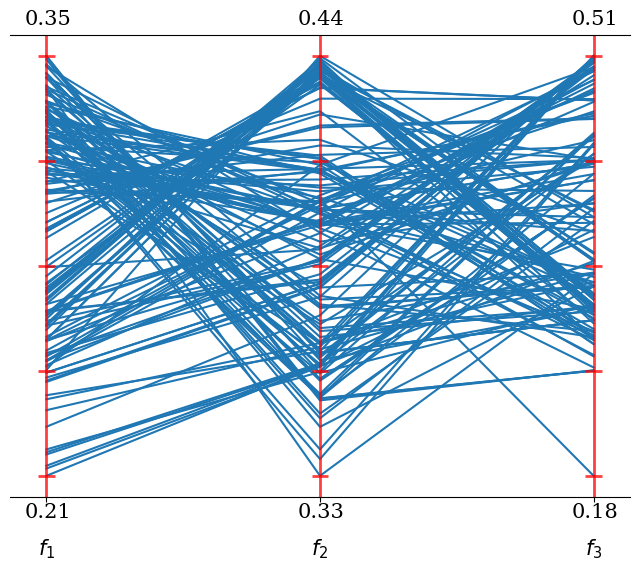

In [94]:
from pymoo.visualization.pcp import PCP
PCP().add(-res.F).show()


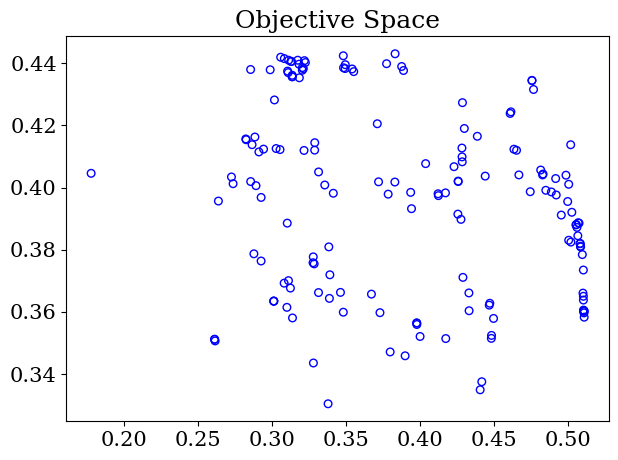

In [99]:
%matplotlib inline
plt.figure(figsize=(7, 5))
plt.scatter(-res.F[:, 2], -res.F[:, 1], s=30, facecolors='none', edgecolors='blue')
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


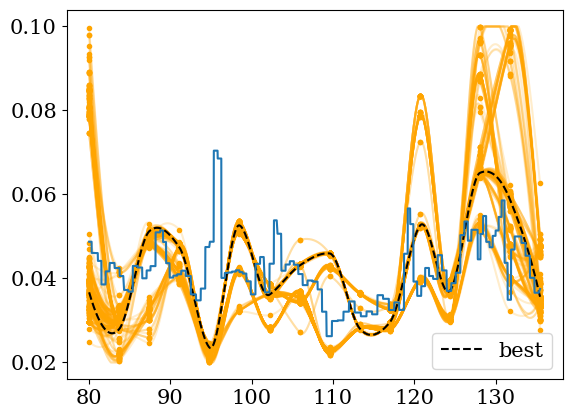

In [107]:
%matplotlib inline
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
fig = plt.figure()
for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.',color="orange")
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    invSR_interpolate[invSR_interpolate<invSR_lims[0]] = invSR_lims[0]
    invSR_interpolate[invSR_interpolate>invSR_lims[1]] = invSR_lims[1]
    plt.plot(depth, invSR_interpolate, "-", alpha=0.2,color="orange")
# plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best")
# plt.plot(depth, interpolator([depth_genes, func_invSR_nominal(depth_genes)], depth), color="red", label="nominal")
plt.plot(depth, func_invSR_nominal(depth))
# invSR_interpolate[invSR_interpolate<0] = 0
plt.legend()
# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

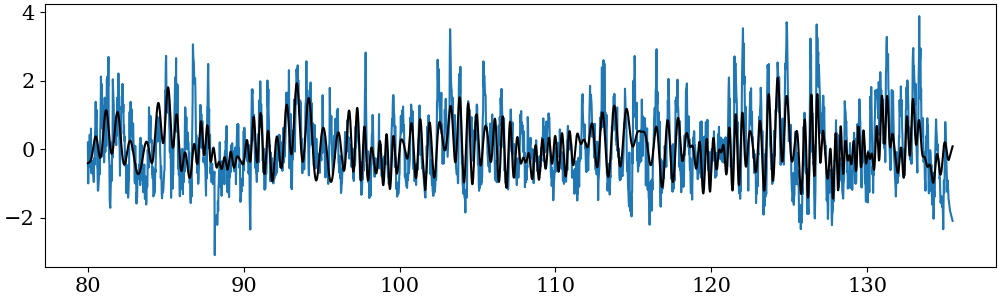

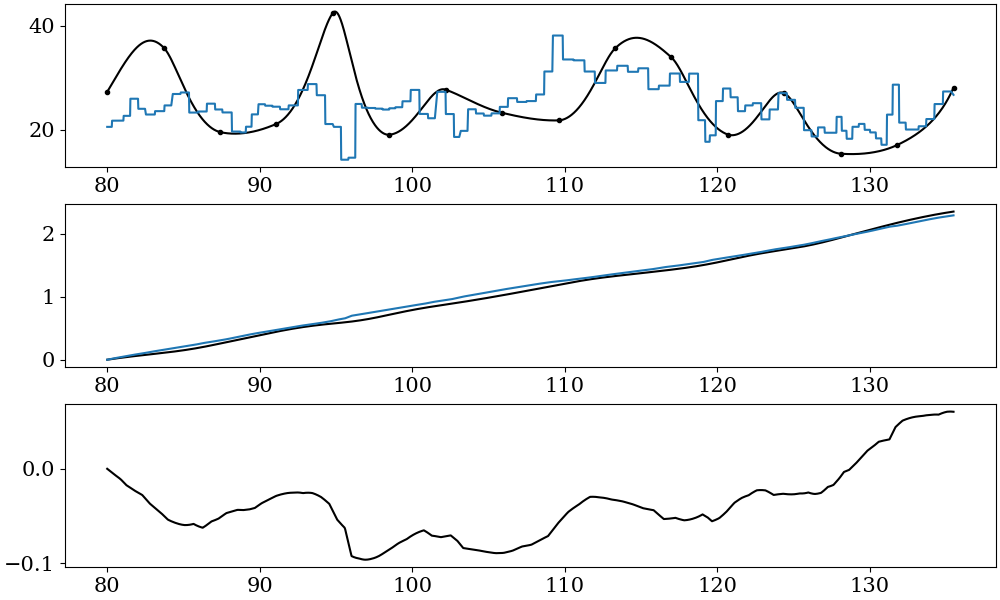

In [108]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, y)
# axs[0].plot(depth_age[0], (depth_age[1]-depth_age[1,0] ))
# for i in range(res.F.shape[0]):

#     # invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
#     time, y_pred = invSR_to_predx([depth_genes, res.X[i]])
    
#     axs[1].plot(depth, y_pred, alpha=0.1, color="black")
#     axs[0].plot(depth, time, alpha=0.3, color="black")
    
time_best, y_pred = invSR_to_predx([depth_genes, invSR_best])

# axs[0].plot(depth, time, color="black")
# 
ax.plot(depth, y_pred, color="black")

time_nominal, y_pred = invSR_to_predx([depth_genes, func_invSR_nominal(depth_genes)])
# axs[1].plot(depth, y_pred,  color="red")
# axs[0].plot(depth, time, color="red")


# axs[1].plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color="black")
# axs[1].plot(depth_genes, res.X[arg_best], '.', color="black")
# axs[1].plot(depth, func_invSR_nominal(depth))
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(10,6))

axs[0].plot(depth, 1/interpolator([depth_genes, res.X[arg_best]], depth), color="black")
axs[0].plot(depth_genes, 1/res.X[arg_best], '.', color="black")
axs[0].plot(depth, 1/func_invSR_nominal(depth))

axs[1].plot(depth, time_best, color="black")
# axs[1].plot(depth, time_nominal)
axs[1].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]))
# axs[1].plot(depth, time_best-time_nominal, color="black")
axs[2].plot(depth, time_best-func_time_nominal(depth)+func_time_nominal(depth[0]), color="black")


# axs[0].plot(depth, interpolator([depth_genes, res.X[i]], depth))

# for i in range(2):
#     axs[i].set_xlim([90, 100])

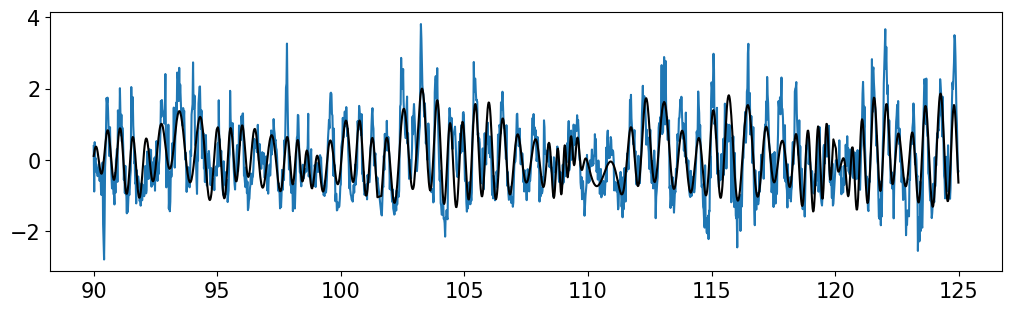

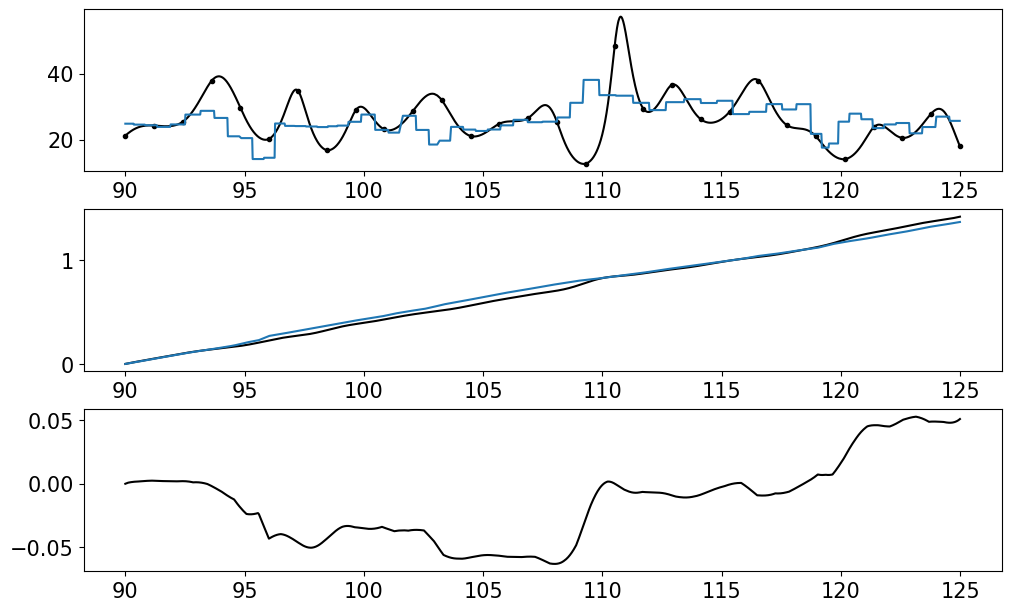

In [97]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, y)
# axs[0].plot(depth_age[0], (depth_age[1]-depth_age[1,0] ))
# for i in range(res.F.shape[0]):

#     # invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
#     time, y_pred = invSR_to_predx([depth_genes, res.X[i]])
    
#     axs[1].plot(depth, y_pred, alpha=0.1, color="black")
#     axs[0].plot(depth, time, alpha=0.3, color="black")
    
time_best, y_pred = invSR_to_predx([depth_genes, invSR_best])

# axs[0].plot(depth, time, color="black")
# 
ax.plot(depth, y_pred, color="black")

time_nominal, y_pred = invSR_to_predx([depth_genes, func_invSR_nominal(depth_genes)])
# axs[1].plot(depth, y_pred,  color="red")
# axs[0].plot(depth, time, color="red")


# axs[1].plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color="black")
# axs[1].plot(depth_genes, res.X[arg_best], '.', color="black")
# axs[1].plot(depth, func_invSR_nominal(depth))
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(10,6))

axs[0].plot(depth, 1/interpolator([depth_genes, res.X[arg_best]], depth), color="black")
axs[0].plot(depth_genes, 1/res.X[arg_best], '.', color="black")
axs[0].plot(depth, 1/func_invSR_nominal(depth))

axs[1].plot(depth, time_best, color="black")
# axs[1].plot(depth, time_nominal)
axs[1].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]))
# axs[1].plot(depth, time_best-time_nominal, color="black")
axs[2].plot(depth, time_best-func_time_nominal(depth)+func_time_nominal(depth[0]), color="black")


# axs[0].plot(depth, interpolator([depth_genes, res.X[i]], depth))

# for i in range(2):
#     axs[i].set_xlim([90, 100])

### In search for optimial number of genes

In [25]:
algorithm = NSGA2(
    pop_size=200,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 500
termination = get_termination("n_gen", N_generations)
N_genes_enemble = np.arange(10, 40, 2)
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
N_ensemble = len(depth_genes_ensemble)

problems = [invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=2, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 


res_ensemble = Parallel(n_jobs=N_ensemble, verbose=100)(delayed(minimize)(problem, algorithm, termination, save_history=True) for problem in problems)


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   1 tasks      | elapsed:  6.5min
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:  6.5min remaining: 42.4min
[Parallel(n_jobs=15)]: Done   3 out of  15 | elapsed:  6.6min remaining: 26.5min


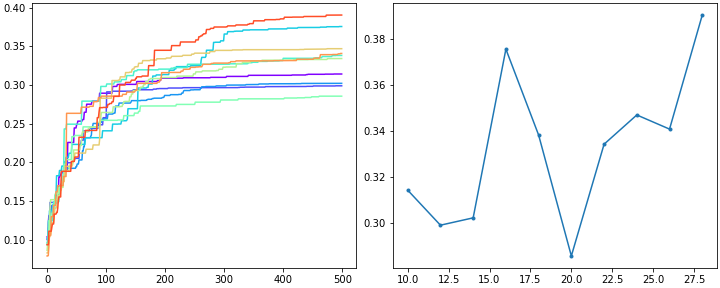

In [50]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])

plt.figure(figsize=(10, 4), constrained_layout=True)
plt.title("Convergence")
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))

# plt.yscale("log")
plt.subplot(1,2,2)
plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')

# MCMC

## In search for SR

In [140]:
arg_best = np.argmin(res.F.sum(axis=1))
invSR_best = res.X[arg_best]
invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 48
params_noise_ini = [0.8, 0.8]
params_ini = np.hstack([params_noise_ini, invSR_best])
pos = params_ini + 1e-4 * np.random.randn(nwalkers, N_genes+len(params_noise_ini))
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)

nwalkers, ndim = pos.shape
log_posterior = log_posterior_rednoise_v1
log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y], fs=fs, interpolator=interpolator, invSR_lims=invSR_lims) 

# log_posterior = log_posterior_whitenoise
# log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolate_CubicSpline,
#                                    invSR_lims=invSR_lims, sigma_lims=[1e-4, 2], prior_freq=prior_params_freq) 

# with Pool(processes=1) as pool:

with JoblibPool(16) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    sampler.run_mcmc(pos, 10000, progress=True)
    # print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|██████████| 10000/10000 [06:14<00:00, 26.74it/s]


In [92]:
# %lprun -f log_posterior_whitenoise_v1  log_posterior_whitenoise_v1(params_ini, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims,  fs=fs)         
%lprun -f log_likelihood_whitenoise  log_likelihood_whitenoise([depth_genes, invSR_best], data=[depth, y],interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims,  fs=fs, sigma=0.8)         
    

Timer unit: 1e-09 s

Total time: 0.0555837 s
File: /users/nhoanghoai/AstroGeo/routines_model.py
Function: log_likelihood_whitenoise at line 244

Line #      Hits         Time  Per Hit   % Time  Line Contents
   244                                           def log_likelihood_whitenoise(invSR, data, fs, sigma, interpolator=interpolate_CubicSpline, *args, **kwargs):
   245                                               """_summary_: 
   246                                               
   247                                                   loglikelihood for the linear model with predictors variable are fourier harmonics of frequencies fs
   248                                                   of fitting the data, when used the age model derived from the invSR.
   249                                                   age model: given points of inverse SR, interpolate with an interpolator and integrate along depth
   250                                                   to obtain time.


In [115]:
samples.shape

(5000, 64, 18)

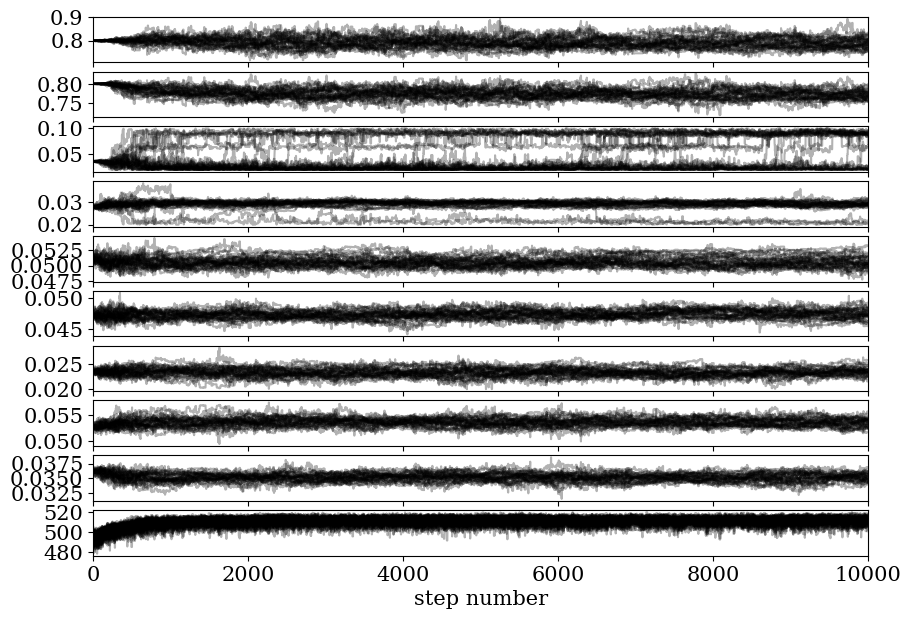

In [148]:
ndim = 10
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
logprob_sample = sampler.get_log_prob()

# labels = ["m", "b", "log(f)"]
for i in range(ndim-1):
    ax = axes[i]
    ax.plot(samples[:, :30, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].plot(logprob_sample, "k", alpha=0.3)
axes[-1].set_xlabel("step number");     

In [142]:
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)
print(flat_samples.shape)

(8640, 18)


In [143]:
depth_genes.shape

(16,)

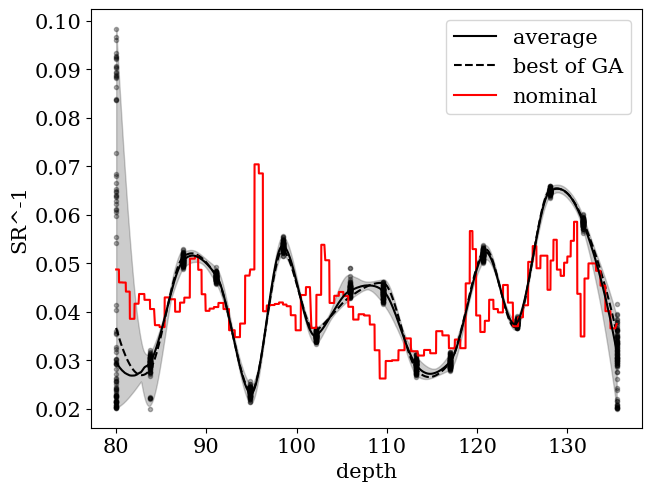

In [146]:
%matplotlib inline
inds = np.random.randint(len(flat_samples), size=4000)
# genes_value = flat_samples[:,1+len(freqs_true)+i]
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,len(params_noise_ini):]], depth) for i in range(8000)])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
alphas = [0.025, 0.975]
alphas = [0.01, 0.99]
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, alphas,axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
[plt.plot(depth_genes, flat_samples[i,len(params_noise_ini):],'.',alpha=0.3,color="black") for i in range(100) ]
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best of GA")
plt.plot(depth, func_invSR_nominal(depth), label="nominal", color="red")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
# plt.plot(depth, invSR, "--", color="red", label="true")
# plt.xlim([90,125])
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()

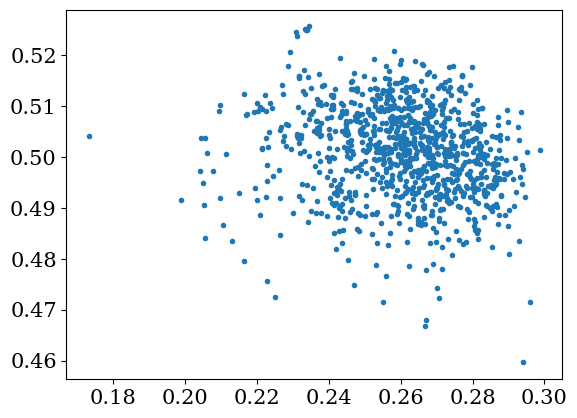

In [151]:
metric_samples = np.array([metric_piecewise([depth_genes, flat_samples[i,len(params_noise_ini):]], [depth, y], fs, interpolator, n_pieces)for i in range(1000) ])
# metr
# plt.figure()
# plt.hist(metric_samples.mean(axis=1))
# plt.hist(metric_samples[:,0])
# plt.hist(metric_samples[:,1])
plt.figure()
# plt.hist(metric_samples.mean(axis=1))
plt.plot(metric_samples[:,0], metric_samples[:,2], '.')
# plt.hist(metric_samples[:,1])

## In search for frequencies

In [155]:
prior_params_freq = np.array([[50.5, 10], [5.525, 0.125], [7.455, 0.015], [17.3, 0.15], [17.85, 0.15], [4.257564, 0.00002]])
prior_params_freq = prior_params_freq/180/3600*np.pi*1e6

In [157]:
log_posterior_rednois_EP

<function routines_model.log_posterior_rednois_EP(params, depth_invSR, data, prior_freq, interpolator=<function interpolate_CubicSpline at 0x000001AFC4AACEA0>, invSR_lims=[0, 2], sigma_lims=[0.0001, 2])>

In [156]:
log_posterior = log_posterior_whitenoise_EP
log_posterior = log_posterior_rednoise_EP

arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 80
params_noise_ini = [0.5]
params_freq_ini = prior_params_freq[:,0]
params_ini = np.hstack([params_noise_ini, params_freq_ini, invSR_best])
# params_best = np.hstack([sigma_true, p0, muy_k, true_genes])
pos_ini = params_ini + 1e-4 * np.random.randn(nwalkers, len(params_ini))
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)

nwalkers, ndim = pos_ini.shape
log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolator,
                                   invSR_lims=invSR_lims, sigma_lims=[1e-4, 2], prior_freq=prior_params_freq) 

print(f"log posterior initial point: {log_probability_testcase(pos_ini[0])}")
# print(f"log posterior best point: {log_probability_testcase(params_best)}")


with Pool(processes=16) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    sampler.run_mcmc(pos_ini, 1000, progress=True)


NameError: name 'log_posterior_rednoise_EP' is not defined

In [17]:
print("acceptance_fraction", sampler.acceptance_fraction.mean())
tau = sampler.get_autocorr_time()
print("autocorr_time",tau)

acceptance_fraction 0.21657687500000003


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 37 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 947.89850158  892.06938662 2082.17496715 1146.17923912 1764.08782734
 1831.10430419  570.13104732  701.74478687  723.4446424  1533.58342356
 1031.72147368 1815.90162815 1675.14237362 1065.79079435  850.74148494
  606.14830093 1089.63293788  598.06922015  944.48579123  640.67079056
  727.65086967  905.33686433  663.36611737 1763.76010677  821.66638015
 1522.90027086  528.05102917  560.67674093 1594.27860273 1029.63562978
  742.56909628 1122.95705446  630.88407567  599.82707087  646.2249346
  821.68929882  781.38116697]

In [21]:
samples = sampler.get_chain()
logprob_sample = sampler.get_log_prob()
samples.shape

(20000, 80, 37)

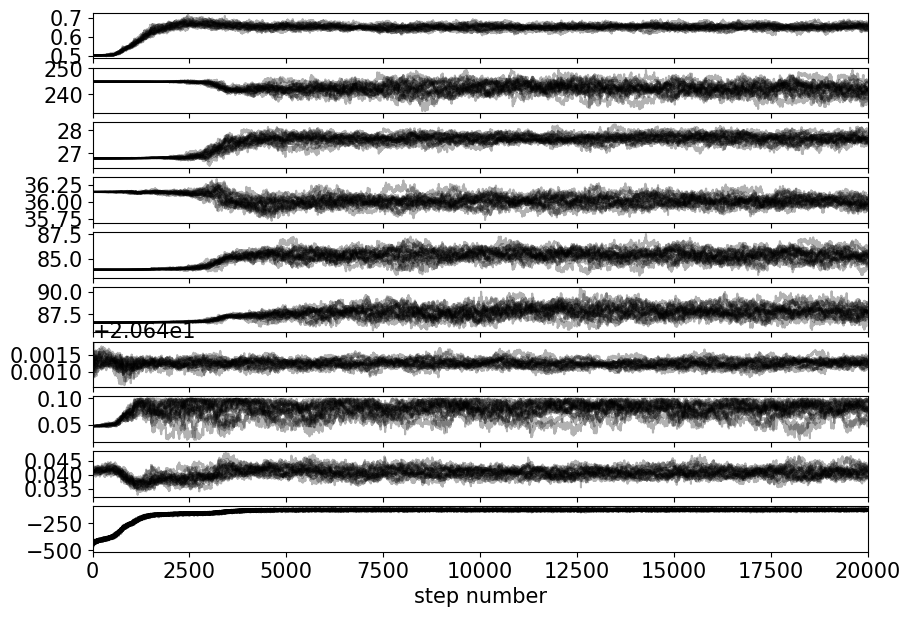

In [24]:
ndim = 10
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

# labels = ["m", "b", "log(f)"]
for i in range(ndim-1):
    ax = axes[i]
    ax.plot(samples[:, :20, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].plot(logprob_sample, "k", alpha=0.3)
axes[-1].set_xlabel("step number");     

In [63]:
flat_samples = sampler.get_chain(discard=5000, thin=200, flat=True)

In [60]:
fs

array([271.72398927, 280.82533348, 328.87002991, 331.50547223,
       265.31565416,  15.50967932,  66.18981807,  50.68013875,
        63.55437575,  48.04469643])

(45.0, 55.0)

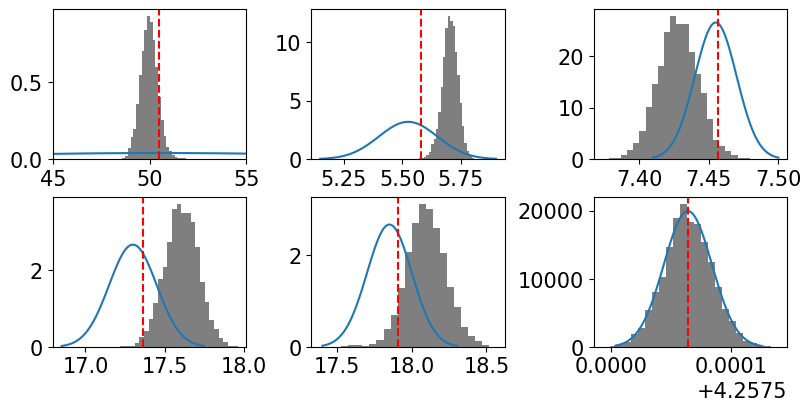

In [70]:
fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
coef = 1/180/3600*np.pi*1e6
freqs_0 = np.hstack([p0, g_k])/coef
for i, ax in enumerate(axs.flatten()):

    # variance = 1
    # sigma = math.sqrt(variance)
    muy, sigma = prior_params_freq[i]/coef
    x = np.linspace(muy - 3*sigma, muy + 3*sigma, 100)
    ax.plot(x, sp.stats.norm.pdf(x, muy, sigma))
    ax.hist(flat_samples[:,1+i]/coef, density=True, color="k", alpha=0.5, bins=25)
    ax.axvline(freqs_0[i], ls="--", color="red")
    plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best")
    
    # ax.hist(2*np.pi/(flat_samples[:,1+i]+flat_samples[:,1])*1e3, density=True, color="k", alpha=0.5, bins=25)
    # ax.axvline(2*np.pi/fs[i-1]*1e3)
axs[0,0].set_xlim(45,55)

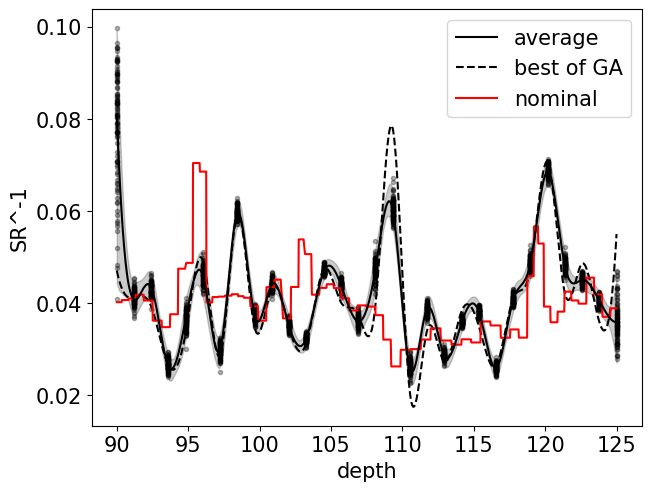

In [141]:
inds = np.random.randint(len(flat_samples), size=4000)
# genes_value = flat_samples[:,1+len(freqs_true)+i]
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,1+6:]], depth) for i in range(4000)])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
alphas = [0.025, 0.975]
alphas = [0.01, 0.99]
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, alphas,axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
[plt.plot(depth_genes, flat_samples[i,1+6:],'.',alpha=0.3,color="black") for i in range(100) ]
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best of GA")
plt.plot(depth, func_invSR_nominal(depth), label="nominal", color="red")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
# plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()

array([0.11036102, 0.12123117])

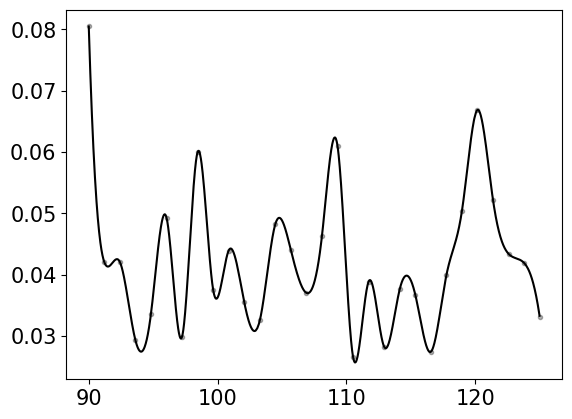

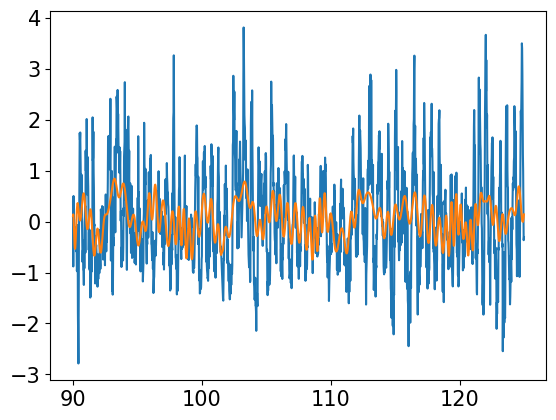

In [155]:
# fig1 = plt.figure(constrained_layout=True)
i= 2
plt.figure()
plt.plot(depth_genes, flat_samples[i,1+6:],'.',alpha=0.3,color="black")
plt.plot(depth, invSR_interpolate_par[i],color="black")
time, y_pred = invSR_to_predx([depth_genes, flat_samples[i,1+6:]])
plt.figure()
plt.plot(depth, y)
plt.plot(depth, y_pred)

metric_samples[2]

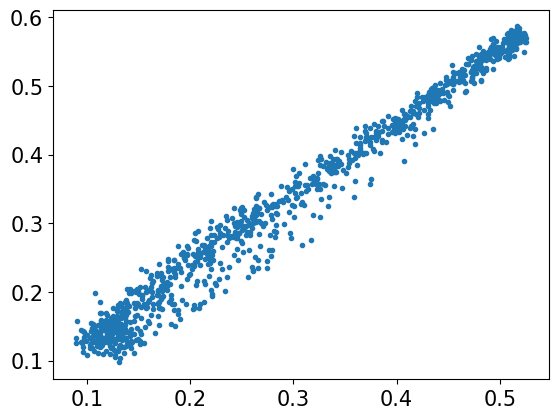

In [132]:
metric_samples = np.array([metric_piecewise([depth_genes, flat_samples[i,7:]], [depth, y], fs, interpolator, n_pieces)for i in range(1000) ])
# metr
# plt.figure()
# plt.hist(metric_samples.mean(axis=1))
# plt.hist(metric_samples[:,0])
# plt.hist(metric_samples[:,1])
plt.figure()
# plt.hist(metric_samples.mean(axis=1))
plt.plot(metric_samples[:,0], metric_samples[:,1], '.')
# plt.hist(metric_samples[:,1])

In [103]:
y_pred_sample.shape

(1000, 1694)

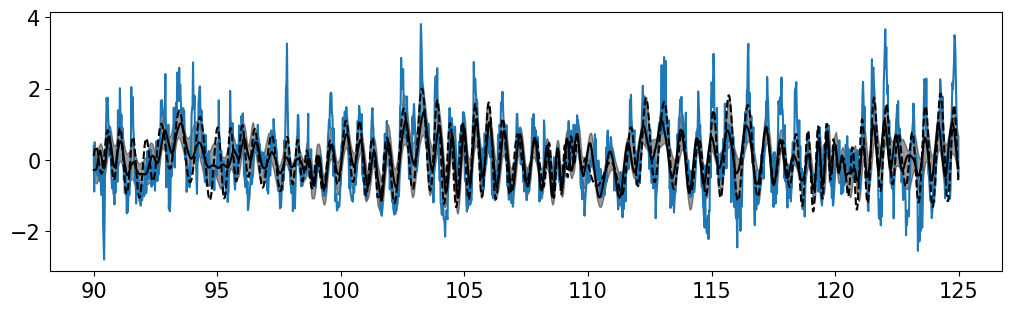

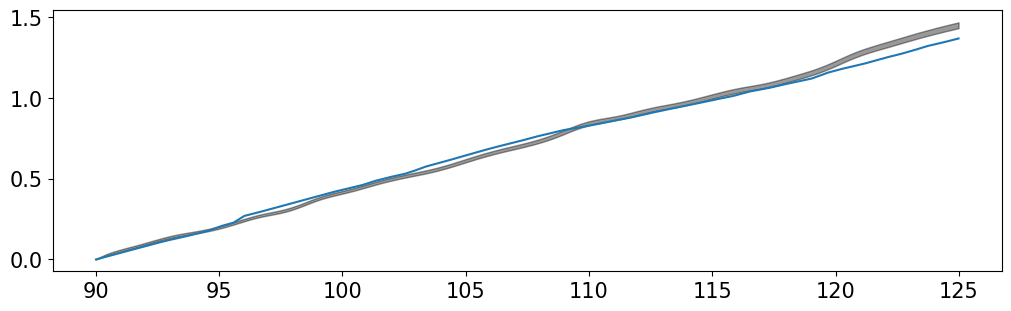

In [122]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, y)

y_pred_sample =  np.array([ invSR_to_predx([depth_genes, flat_samples[i,7:]])[1] for i in range(1000)])
alphas = [0.01, 0.99]
alphas = [0.05, 0.95]

ypred_lo, ypred_up = np.quantile(y_pred_sample, alphas,axis=0)

time_best, y_pred = invSR_to_predx([depth_genes, invSR_best])
# axs[0].plot(depth, time, color="black")
# 
ax.plot(depth, y_pred, "--", color="black")
ax.fill_between(depth, ypred_lo, ypred_up, color="black", alpha=0.4)
ax.plot(depth, np.median(y_pred_sample, axis=0), color="black")

# ax.set_xlim([90,100])
# time_nominal, y_pred = invSR_to_predx([depth_genes, func_invSR_nominal(depth_genes)])


fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
time_sample =  np.array([ invSR_to_predx([depth_genes, flat_samples[i,7:]])[0] for i in range(1000)])
alphas = [0.05, 0.95]
lo, up = np.quantile(time_sample, alphas,axis=0)
ax.fill_between(depth, lo, up, color="black", alpha=0.4)
ax.plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]))


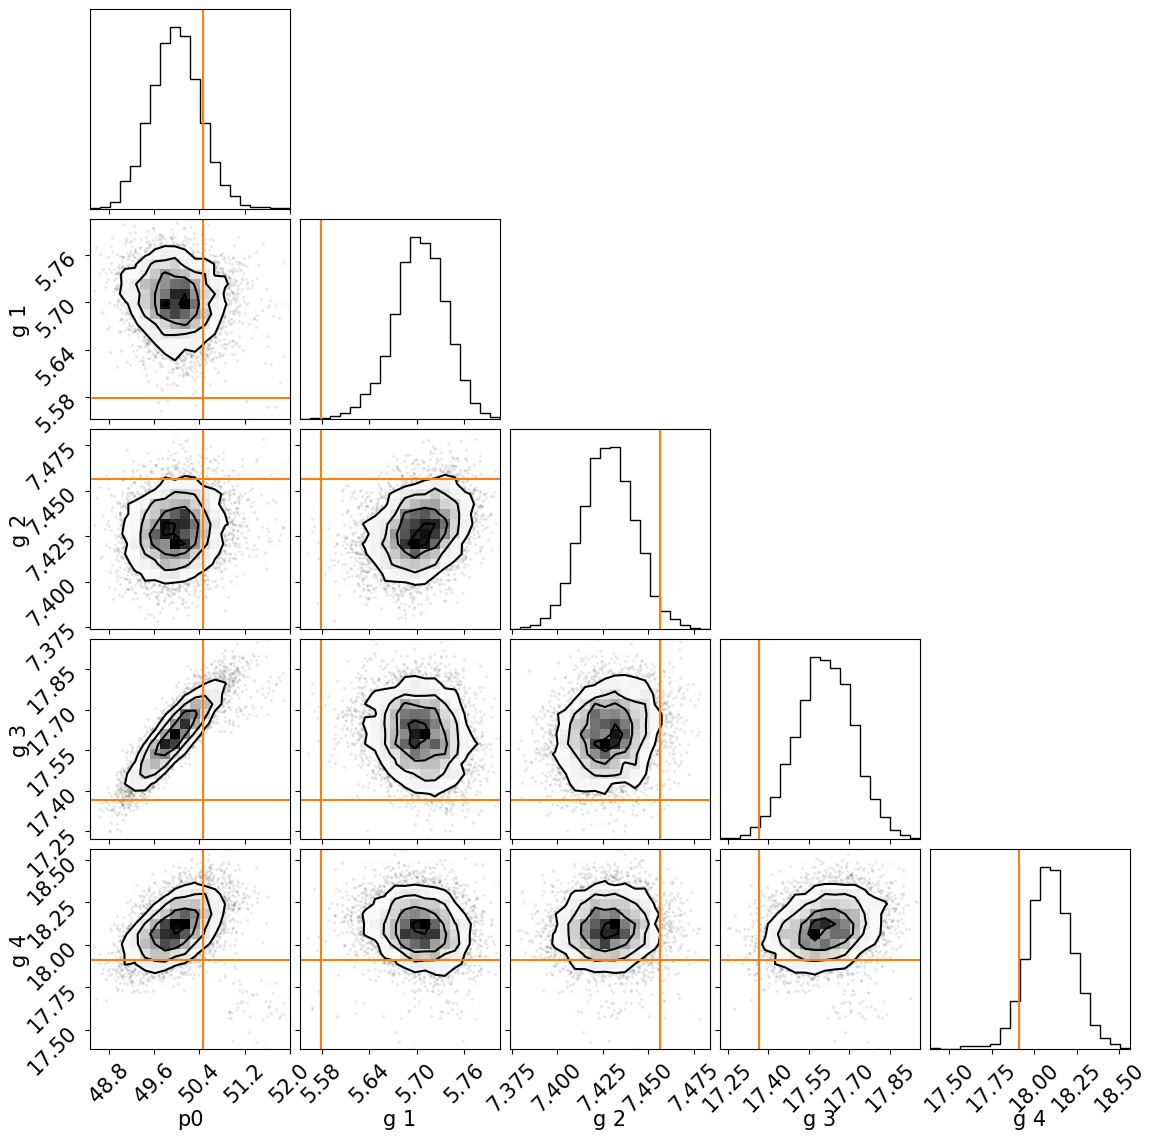

In [68]:
# labels = list(map(r"invSR{0}".format, range(1, N_genes + 1)))
# n_genes_plot = N_genes
n_genes_plot = 5
coef = 1/180/3600*np.pi*1e6

# true_values = np.hstack([[sigma_true, rho_true], true_genes[:n_genes_plot]])
labels = ["p0"] + [f"g {i}" for i in range(1,5)]
fig = corner.corner(
    flat_samples[:,1:6]/coef, labels=labels
)
corner.overplot_lines(fig, np.hstack([p0, g_k[:4]])/coef, color="C1",label="GA")
# corner.overplot_lines(fig, invSR_best[:n_genes_plot], color="C1",label="GA")
# corner.overplot_points(fig, invSR_best[None,:n_genes_plot], marker="s", color="C1")
# plt.legend()